In [217]:
# Interactive
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Standard library
import warnings
import os
from functools import reduce

# Data
import numpy as np
import pandas as pd
from numpy.random import seed

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from model_eval import plot_histograms, compute_average_accuracy

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, f1_score, balanced_accuracy_score, make_scorer
import xgboost as xgb
import joblib
# Imbalanced Learning
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

print('XGB Version',xgb.__version__)

XGB Version 1.7.2


## Global Settings

In [202]:
# Random state
seed = 127
rs = np.random.RandomState(seed) 

# Train and test data paths
train_path = '../data/train_test/'
test_path = '../data/train_test/'

# Other paths
model_path = '../outputs/models/'
plot_path = '../outputs/plots/'

# K-fold
folds = 5

# Top x important features to visualize
top_num_features = 20

warnings.filterwarnings("ignore")

## Data

In [203]:
train_X, train_y = pd.read_parquet(train_path + 'train_X.parquet'), pd.read_parquet(train_path + 'train_y.parquet').to_numpy().ravel()
test_X, test_y = pd.read_parquet(test_path + 'test_X.parquet'), pd.read_parquet(test_path + 'test_y.parquet').to_numpy().ravel()

In [204]:
train_X.shape, train_y.shape

((32950, 20), (32950,))

In [205]:
test_X.shape, test_y.shape

((8238, 20), (8238,))

## Baseline Model

We begin by loading the baseline boosting classifier that we obtained from a grid search and use its parameters as a starting point for our k-fold cross validation:

In [206]:
base_model = joblib.load(model_path + 'baseline_model.joblib.dat')

In [207]:
# There are two functions for obtaining the parameters and they may not be same
set(base_model.get_params().keys()) - set(base_model.get_xgb_params().keys())

{'callbacks',
 'early_stopping_rounds',
 'enable_categorical',
 'eval_metric',
 'feature_types',
 'importance_type',
 'missing',
 'n_estimators',
 'use_label_encoder'}

### Parameter Set

We can use the parameter set guided by the baseline model as a starting point and tune these parameters using k-fold cross validation:

In [208]:
# Parameters for the booster object
# See https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster
params_set = {'objective': 'binary:logistic',
            'booster': 'gbtree',
            'colsample_bylevel': 1,
            'colsample_bynode': 1,
            'colsample_bytree': 0.8,
            'early_stopping_rounds': None,
            'predictor': 'cpu_predictor',
            'eval_metric': 'logloss',
            'gamma': 3,
            'learning_rate': 0.001,
            'max_depth': 3,
            'min_child_weight': 5,
            'n_jobs': -1,
            'random_state': seed,
            'reg_alpha': 0,
            'reg_lambda': 1,
            'subsample': 0.5,
            'tree_method': 'hist'}

In [209]:
# Write the parameters to a file
joblib.dump(params_set, model_path + 'param_set.joblib')

['../outputs/models/param_set.joblib']

## Over Sampling and Under Sampling

To address data imbalance, we will use two techniques for each parameter set we try:

* Smote (over sampling the minority class) combined with edited nearest neighbors (under sampling the majority class)

* Borderline Smote, which is another implementation of SMOTE, with no under sampling

For each parameter set, we will use the technique that yields the best model. There could potentially be 5 fits per 5-fold cv multiplied by 2 (two alternative sampling techniques); in other words, there could potentially be a total of 10 fits for each parameter set we try.

First, create an unfitted transformer that combines SMOTE and ENN: 

In [210]:
# Smote
sm = SMOTE(
    sampling_strategy='auto', # Oversample the minority class
    random_state=rs, # Random state
    k_neighbors=NearestNeighbors(n_neighbors=30, n_jobs=-1), # Number of nearest neighbors to used to construct synthetic samples
)
# Edited Nearest Neighbors
enn = EditedNearestNeighbours(
    sampling_strategy='auto', # Undersample the majority class
    n_neighbors=30, # Number of nearest neighbors to used to construct synthetic samples
    kind_sel='mode', # Majority vote of the neighbors will be used in order to exclude a sample (more conservative approach than 'all')
)
# Smote + Edited Nearest Neighbors, an instance of imblearn.combine._smote_enn.SMOTEENN
smenn = SMOTEENN(
    sampling_strategy='auto',
    random_state=rs,
    smote=sm,
    enn=enn,
    n_jobs=-1
)

Next, create an unfitted `BorderlineSMOTE` transformer. Note that `kind='borderline-1` and `kind='borderline-2` will classify each sample 
to be: 

* noise, i.e. all nearest-neighbors are from a different class than the one of $x_{i}$
  
* in danger, i.e. at least half of the nearest neighbors are from the same class than $x_{i}$
  
* safe, i.e. all nearest neighbors are from the same class than $x_{i}$

Borderline-1 will use samples *in danger* to generate new samples while borderline-2 will consider all samples for any class.

In [211]:
borderline_sm = BorderlineSMOTE(
    sampling_strategy='auto',
    random_state=rs,
    k_neighbors=NearestNeighbors(n_neighbors=30, n_jobs=-1),
    kind='borderline-2'
)

We will save these transformers to disk, then, at train time, we load fresh instances of these transformers for each fold to *sample the training data for that specific fold*. This prevents data leakage.

In [212]:
joblib.dump(smenn, '../outputs/pipeline/smenn.joblib')
joblib.dump(borderline_sm, '../outputs/pipeline/borderline_sm.joblib')

['../outputs/pipeline/smenn.joblib']

['../outputs/pipeline/borderline_sm.joblib']

## Training with K-fold CV

In [213]:
# Feature importance output container (list of pandas data frames)
feat_imp_list = []
# Out-of-fold prediction container
oof = []
# An instance of StratifiedKFold, whose split method generates indices to split data into training and validation set
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rs)

# Fives rounds of fitting
for fold, (train_idx, valid_idx) in enumerate(skf.split(X=train_X, y=train_y)):
    
    # Print messages to console
    print('#'* 80)
    print('# Fold',fold + 1)
    print('# Training set size', len(train_idx), 'Validation set size', len(valid_idx))
    print(f'# Training with 100% of the samples of the current fold')
    print('#'* 80)
    
    # Check that the indices are indeed disjoint for training and validation set
    print('The training and validation sets are disjoint:', set(train_idx).isdisjoint(set(valid_idx)))
    
    # For each fold, we need to process the training data and target label using fresh instances of the preprocessor and label encoder
    # This is because the preprocessor and label encoder must be fitted on the training data of the current fold to avoid data leakage
    # Note, recursive feature elimination that ends the preprocessor pipeline is not stochastic since we used a decision tree classifier 
    # Therefore, each fresh instance of the preprocessor will lead to the same features being selected
    preprocessor = joblib.load('../outputs/pipeline/preprocessor.joblib')
    label_encoder = joblib.load('../outputs/pipeline/label_encoder.joblib')
    # Check that neither of the objects are fitted
    try:
        preprocessor.transform(train_X.iloc[train_idx])
    except:
        print('Preprocessor is not fitted yet')
        
    try:
        check_is_fitted(label_encoder)
    except:
        print('Label encoder is not fitted yet')
        
    # Fit and transform the preprocessor and label encoder on the training data of the current fold
    fold_train_X = preprocessor.fit_transform(train_X.iloc[train_idx], train_y[train_idx])
    fold_train_y = label_encoder.fit_transform(train_y[train_idx])
    # Only transform (not fit) the validation data of the current fold
    fold_valid_X = preprocessor.transform(train_X.iloc[valid_idx])
    fold_valid_y = label_encoder.transform(train_y[valid_idx])
    # Store fitted preprocessor and label encoder
    joblib.dump(preprocessor, f'../outputs/pipeline/preprocessor_fold_{fold}.joblib')
    joblib.dump(label_encoder, f'../outputs/pipeline/label_encoder_fold_{fold}.joblib')
    
    # Print messages to console
    print('-- Training set size after preprocessor', fold_train_y.shape[0], '-- Validation set size after preprocessor', fold_valid_y.shape[0])
    print('-- Positive class proportions (Train)', (fold_train_y.sum() / len(fold_train_y)).round(2), '-- Positive class proportions (Validate)', (fold_valid_y.sum() / len(fold_valid_y)).round(2))
    
    # Fit and resample the training data of the current fold
    fold_train_X, fold_train_y = joblib.load('../outputs/pipeline/smenn.joblib').fit_resample(fold_train_X, fold_train_y)
    # Print messages to console
    print('-- Training set size after sampling', fold_train_y.shape[0], '-- Positive class proportions after sampling', (fold_train_y.sum() / len(fold_train_y)).round(2))
    
    # Fit the model on the training data of the current fold
    feature_names = preprocessor['recursive_feature_selection'].get_feature_names_out().tolist()
    dtrain = xgb.DMatrix(data=fold_train_X, label=fold_train_y, feature_names=feature_names)
    dvalid = xgb.DMatrix(data=fold_valid_X, label=fold_valid_y, feature_names=feature_names)
    model = xgb.train(
        params=params_set,
        dtrain=dtrain,
        num_boost_round=2000, # Same as n_estimators in sklearn API
        evals=[(dtrain, 'train'), (dvalid, 'validate')], # List of validation sets to be evaluated during training
        verbose_eval=200, # Print messages to console every 'verbose_eval' rounds
    )
    model.save_model(model_path + f'model_fold_{fold + 1}.xgb')
    
    # Feature importance for the current fold
    # The booster object has a get_score method that returns a dictionary of feature names and their importance scores
    feat_imp = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature': feat_imp.keys(), f'importance_{fold + 1}': feat_imp.values()})
    # Add the current fold's feature importance to the container
    feat_imp_list.append(df)
    
    # Out-of-fold prediction for the current fold
    oof_pred = model.predict(data=dvalid)
    score = balanced_accuracy_score(y_true=fold_valid_y, y_pred=oof_pred > 0.5)
    # Zero rule predictions
    fold_valid_y_zeror = np.zeros_like(fold_valid_y)
    score_zeror = balanced_accuracy_score(y_true=fold_valid_y, y_pred=fold_valid_y_zeror)
    print(f'Balanced Accuracy for fold {fold + 1} = {score:.4f}')
    print(f'Zero Rule Accuracy for fold {fold + 1} = {score_zeror:.4f}')
    
    # Store predictions for the current fold
    df = pd.DataFrame({'target': fold_valid_y, 'predictions': oof_pred})
    oof.append(df)
    
    # Remove bindings so gc can collect the objects once reference count is zero
    del fold_train_X, fold_train_y, fold_valid_X, fold_valid_y, dtrain, dvalid, model, score, score_zeror

################################################################################
# Fold 1
# Training set size 26360 Validation set size 6590
# Training with 100% of the samples of the current fold
################################################################################
The training and validation sets are disjoint: True
Preprocessor is not fitted yet
Label encoder is not fitted yet


['../outputs/pipeline/preprocessor_fold_0.joblib']

['../outputs/pipeline/label_encoder_fold_0.joblib']

-- Training set size after preprocessor 26360 -- Validation set size after preprocessor 6590
-- Positive class proportions (Train) 0.11 -- Positive class proportions (Validate) 0.11
-- Training set size after sampling 42172 -- Positive class proportions after sampling 0.45
[0]	train-logloss:0.69265	validate-logloss:0.69266
[200]	train-logloss:0.60820	validate-logloss:0.67860
[400]	train-logloss:0.54666	validate-logloss:0.65259
[600]	train-logloss:0.49907	validate-logloss:0.62484
[800]	train-logloss:0.46197	validate-logloss:0.59587
[1000]	train-logloss:0.43246	validate-logloss:0.57149
[1200]	train-logloss:0.40803	validate-logloss:0.55370
[1400]	train-logloss:0.38780	validate-logloss:0.53409
[1600]	train-logloss:0.36979	validate-logloss:0.51648
[1800]	train-logloss:0.35335	validate-logloss:0.49518
[1999]	train-logloss:0.33852	validate-logloss:0.47833
Balanced Accuracy for fold 1 = 0.7121
Zero Rule Accuracy for fold 1 = 0.5000
##############################################################

['../outputs/pipeline/preprocessor_fold_1.joblib']

['../outputs/pipeline/label_encoder_fold_1.joblib']

-- Training set size after preprocessor 26360 -- Validation set size after preprocessor 6590
-- Positive class proportions (Train) 0.11 -- Positive class proportions (Validate) 0.11
-- Training set size after sampling 42390 -- Positive class proportions after sampling 0.45
[0]	train-logloss:0.69265	validate-logloss:0.69345
[200]	train-logloss:0.60854	validate-logloss:0.63442
[400]	train-logloss:0.54660	validate-logloss:0.59178
[600]	train-logloss:0.49838	validate-logloss:0.55135
[800]	train-logloss:0.46087	validate-logloss:0.52440
[1000]	train-logloss:0.43136	validate-logloss:0.50444
[1200]	train-logloss:0.40749	validate-logloss:0.48742
[1400]	train-logloss:0.38865	validate-logloss:0.47561
[1600]	train-logloss:0.37272	validate-logloss:0.46316
[1800]	train-logloss:0.35818	validate-logloss:0.44908
[1999]	train-logloss:0.34340	validate-logloss:0.43891
Balanced Accuracy for fold 2 = 0.7110
Zero Rule Accuracy for fold 2 = 0.5000
##############################################################

['../outputs/pipeline/preprocessor_fold_2.joblib']

['../outputs/pipeline/label_encoder_fold_2.joblib']

-- Training set size after preprocessor 26360 -- Validation set size after preprocessor 6590
-- Positive class proportions (Train) 0.11 -- Positive class proportions (Validate) 0.11
-- Training set size after sampling 42153 -- Positive class proportions after sampling 0.45
[0]	train-logloss:0.69264	validate-logloss:0.69343
[200]	train-logloss:0.60548	validate-logloss:0.67434
[400]	train-logloss:0.54168	validate-logloss:0.64564
[600]	train-logloss:0.49320	validate-logloss:0.61062
[800]	train-logloss:0.45591	validate-logloss:0.57714
[1000]	train-logloss:0.42675	validate-logloss:0.54845
[1200]	train-logloss:0.40324	validate-logloss:0.52582
[1400]	train-logloss:0.38423	validate-logloss:0.50702
[1600]	train-logloss:0.36947	validate-logloss:0.48808
[1800]	train-logloss:0.35544	validate-logloss:0.47491
[1999]	train-logloss:0.34264	validate-logloss:0.46628
Balanced Accuracy for fold 3 = 0.7064
Zero Rule Accuracy for fold 3 = 0.5000
##############################################################

['../outputs/pipeline/preprocessor_fold_3.joblib']

['../outputs/pipeline/label_encoder_fold_3.joblib']

-- Training set size after preprocessor 26360 -- Validation set size after preprocessor 6590
-- Positive class proportions (Train) 0.11 -- Positive class proportions (Validate) 0.11
-- Training set size after sampling 42218 -- Positive class proportions after sampling 0.45
[0]	train-logloss:0.69266	validate-logloss:0.69266
[200]	train-logloss:0.60954	validate-logloss:0.67320
[400]	train-logloss:0.54865	validate-logloss:0.63787
[600]	train-logloss:0.50193	validate-logloss:0.59847
[800]	train-logloss:0.46435	validate-logloss:0.56401
[1000]	train-logloss:0.43432	validate-logloss:0.53938
[1200]	train-logloss:0.40981	validate-logloss:0.51819
[1400]	train-logloss:0.39027	validate-logloss:0.50334
[1600]	train-logloss:0.37419	validate-logloss:0.48620
[1800]	train-logloss:0.35898	validate-logloss:0.46829
[1999]	train-logloss:0.34520	validate-logloss:0.45365
Balanced Accuracy for fold 4 = 0.7346
Zero Rule Accuracy for fold 4 = 0.5000
##############################################################

['../outputs/pipeline/preprocessor_fold_4.joblib']

['../outputs/pipeline/label_encoder_fold_4.joblib']

-- Training set size after preprocessor 26360 -- Validation set size after preprocessor 6590
-- Positive class proportions (Train) 0.11 -- Positive class proportions (Validate) 0.11
-- Training set size after sampling 42336 -- Positive class proportions after sampling 0.45
[0]	train-logloss:0.69266	validate-logloss:0.69267
[200]	train-logloss:0.60966	validate-logloss:0.67426
[400]	train-logloss:0.54817	validate-logloss:0.64669
[600]	train-logloss:0.50132	validate-logloss:0.61171
[800]	train-logloss:0.46540	validate-logloss:0.57941
[1000]	train-logloss:0.43701	validate-logloss:0.55148
[1200]	train-logloss:0.41361	validate-logloss:0.52929
[1400]	train-logloss:0.39561	validate-logloss:0.51156
[1600]	train-logloss:0.37893	validate-logloss:0.49878
[1800]	train-logloss:0.36369	validate-logloss:0.48699
[1999]	train-logloss:0.34963	validate-logloss:0.47345
Balanced Accuracy for fold 5 = 0.7255
Zero Rule Accuracy for fold 5 = 0.5000


* Based on experimentations, the combination of SMOTE and Edited nearest neighbors tends to lead to the lowest log-loss these parameter and features sets.

### Predictions on Validation Sets

We can visualize the out-of-fold predictions and compare the shape of their distributions to those of the true target labels:  

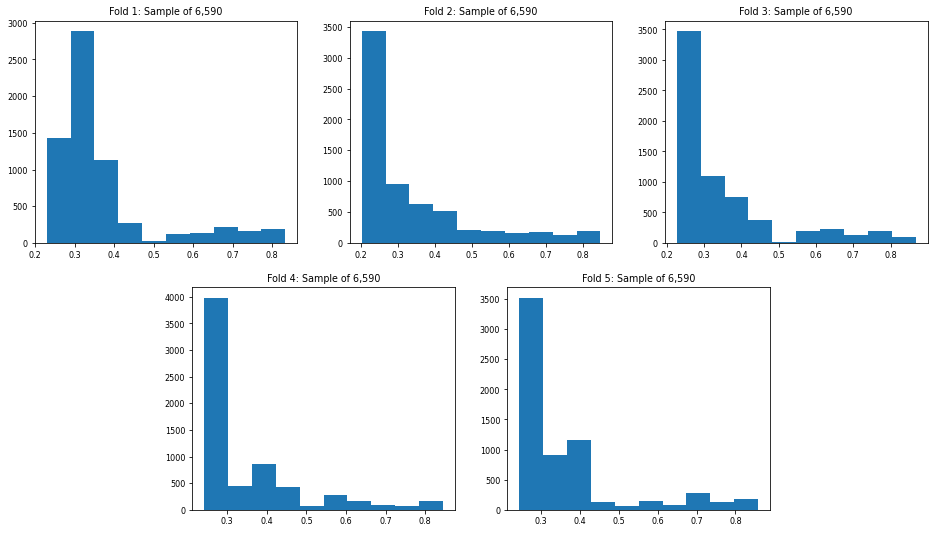

In [214]:
plot_histograms('predictions', oof, path='../outputs/plots/predictions_on_validation_set.pdf')

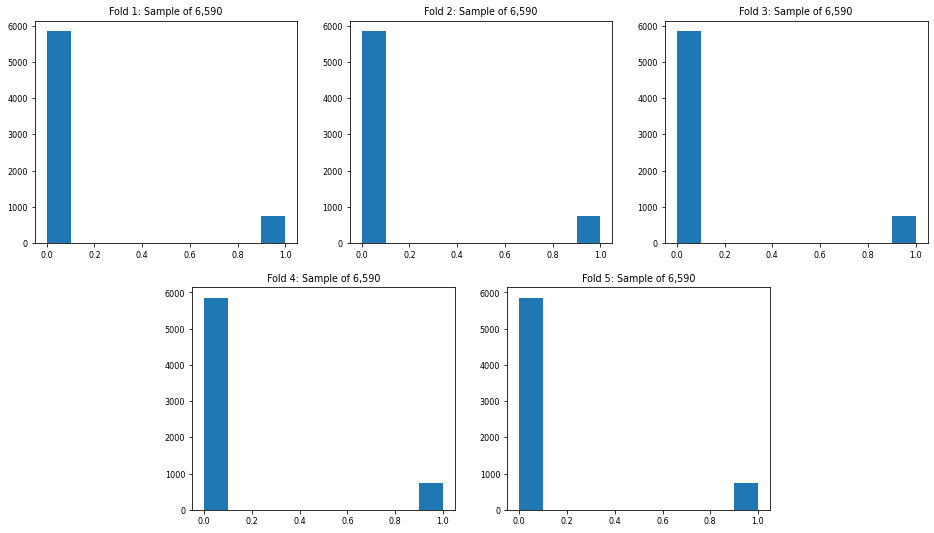

In [215]:
plot_histograms('target', oof)

As can be seen, the model predictions have right skewed distributions across all five folds, which indicates that the model has some predictive power. However, it is not perfect. We can quantify the overall balanced accuracy across these five folds by obtaining, for each fold, one measure of accuracy and taking the mean:

In [225]:
compute_average_accuracy(oof)

0.7179385023185085

Another way to measure model performance is to compare the overall prediction accuracy to the so-called 'dumb' guess metric. For binary classification using log loss as the evaluation metric, there is the magic number ~$0.693$, which is the value of the log loss function when predictions are simply random guesses for both classes with probability 0.5.

In [228]:
actual = [0, 0, 1, 0, 0, 0, 1, 1, 0, 1]
predictions = [
    [0.5, 0.5],
    [0.5, 0.5],
    [0.5, 0.5],
    [0.5, 0.5],
    [0.5, 0.5],
    [0.5, 0.5],
    [0.5, 0.5],
    [0.5, 0.5],
    [0.5, 0.5],
    [0.5, 0.5],
]

print('Random Guess Log Loss Metric =', log_loss(y_true=actual, y_pred=predictions))

Random Guess Log Loss Metric = 0.6931471805599453


As can be seen in the cross validation output, the log loss values for our model are generally in the range between 0.43 to 0.47.

## Feature Importance

In [229]:
# Order feature importance for each fold
for i in range(5):
    feat_imp_list[i].sort_values(by=f'importance_{i + 1}', ascending=True, inplace=True)

<AxesSubplot:title={'center':'Feature importance for fold 1'}, ylabel='feature'>

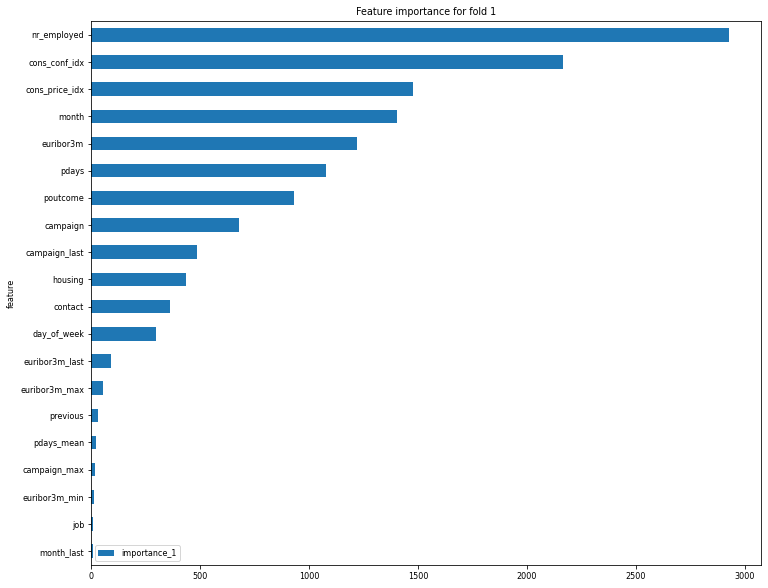

<AxesSubplot:title={'center':'Feature importance for fold 2'}, ylabel='feature'>

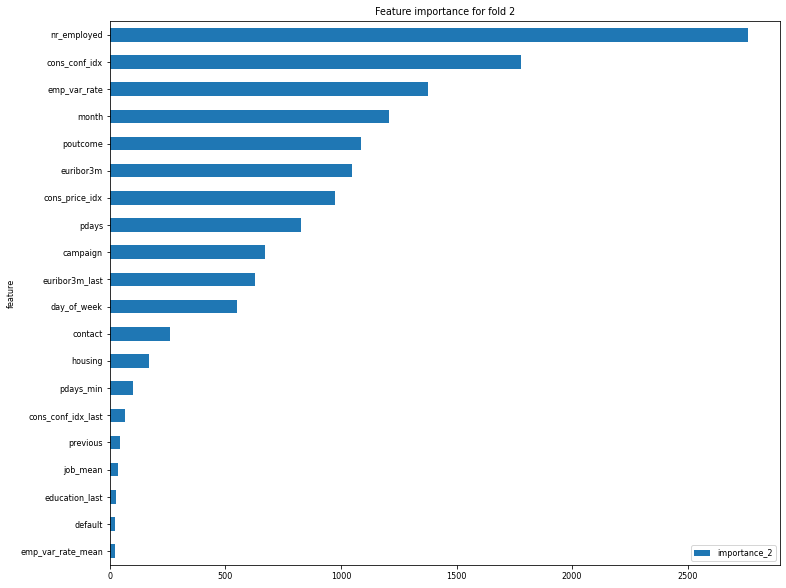

<AxesSubplot:title={'center':'Feature importance for fold 3'}, ylabel='feature'>

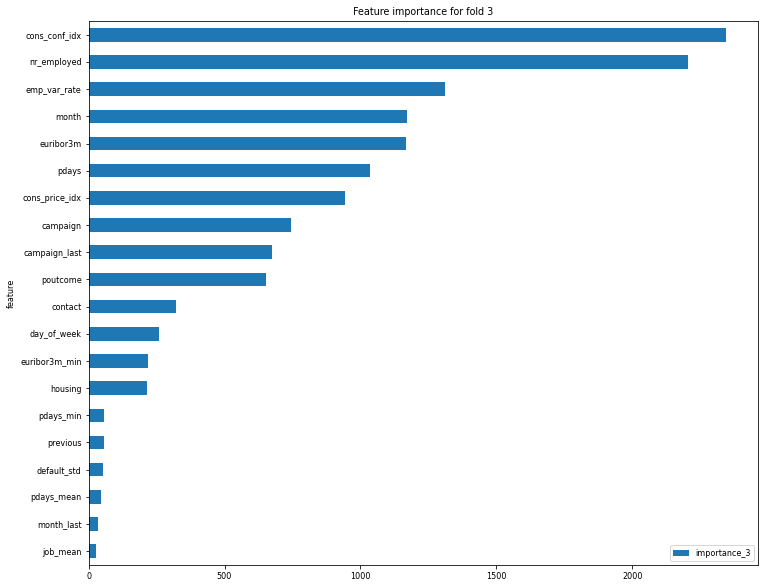

<AxesSubplot:title={'center':'Feature importance for fold 4'}, ylabel='feature'>

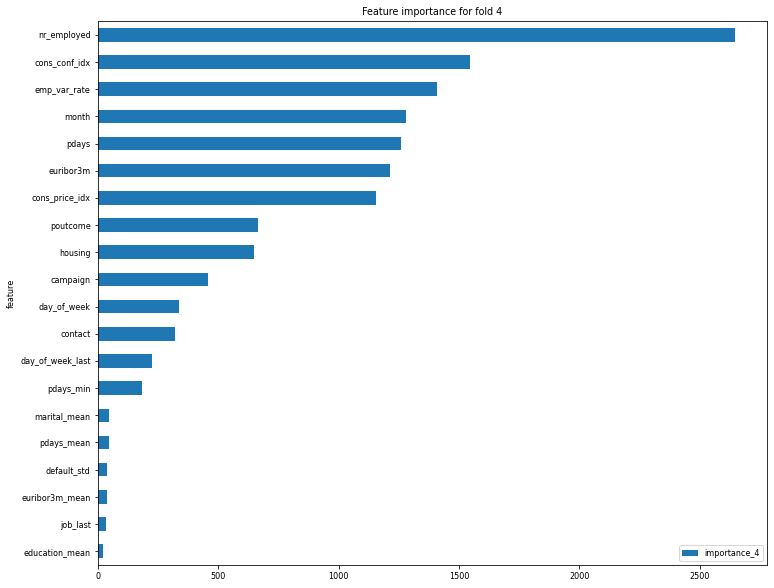

<AxesSubplot:title={'center':'Feature importance for fold 5'}, ylabel='feature'>

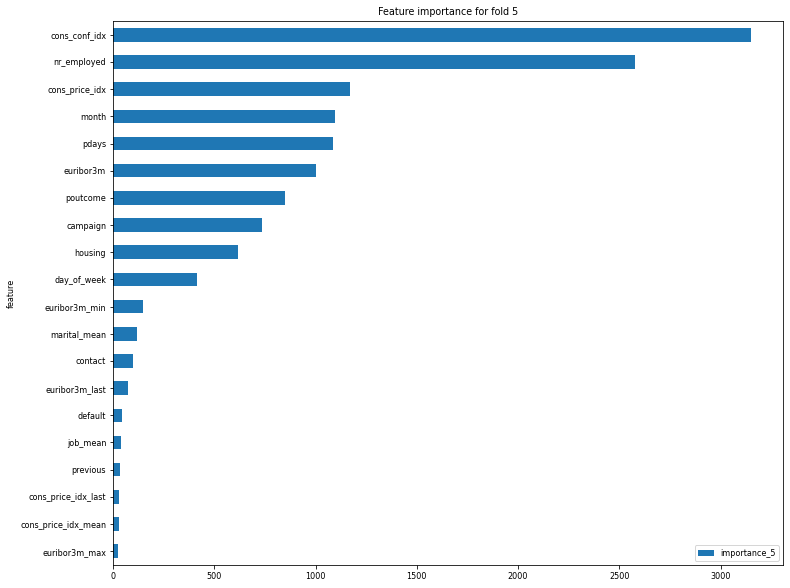

In [230]:
for i in range(5):
    feat_imp_list[i].iloc[-top_num_features:].plot.barh(x='feature', y=f'importance_{i + 1}', figsize=(12, 10), title=f'Feature importance for fold {i + 1}');
    plt.savefig(f'../outputs/plots/feature_importance_fold_{i + 1}.pdf')
    plt.show()

## Predictions on Test Data

Finally, we make predictions on the test data. For each model, we generate one set of predictions on the test data and then take the average:

In [231]:
pred = np.zeros_like(test_y)
avg_test_y = np.zeros_like(test_y)
for i in range(5):
    # Initialize the model
    model = xgb.Booster()
    # Load the model
    model.load_model(model_path + f'model_fold_{i + 1}.xgb')
    # Processor the test set
    fold_test_X = joblib.load('../outputs/pipeline/preprocessor_fold_' + str(i) + '.joblib').transform(test_X)
    # Make predictions on the test set
    pred += model.predict(xgb.DMatrix(data=fold_test_X))
# Average the predictions
pred /= 5
pred = pred.astype('float64')

Distribution of predictions:

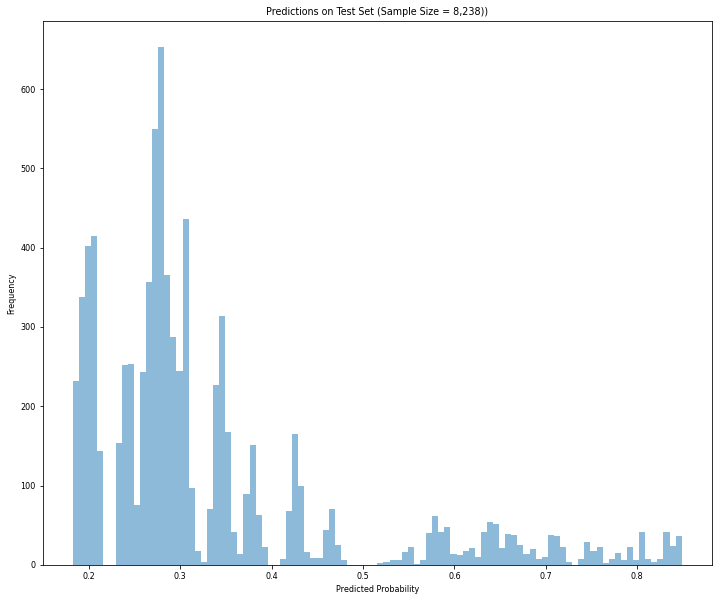

In [232]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.hist(pred, bins=100, alpha=0.5);
plt.title(f'Predictions on Test Set (Sample Size = {len(pred):,}))')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.savefig('../outputs/plots/predictions_on_test_set.pdf')
plt.show();